In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import rioxarray as rxr

In [15]:
gfc = rxr.open_rasterio("../data/global_forest_change_2023_v1_11.tif")
tree_cover = rxr.open_rasterio("../data/Percent_Tree_Cover.tif")
bfm = rxr.open_rasterio("../../R/renv/data/bfm.tif")

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [3]:
aoi = gpd.read_file("../data/adm_2/lao_admbnda_adm2_ngd_20191112.shp").explode()
aoi_geometry = aoi[aoi["ADM2_EN"] == "Chomphet"]["geometry"].iloc[0]

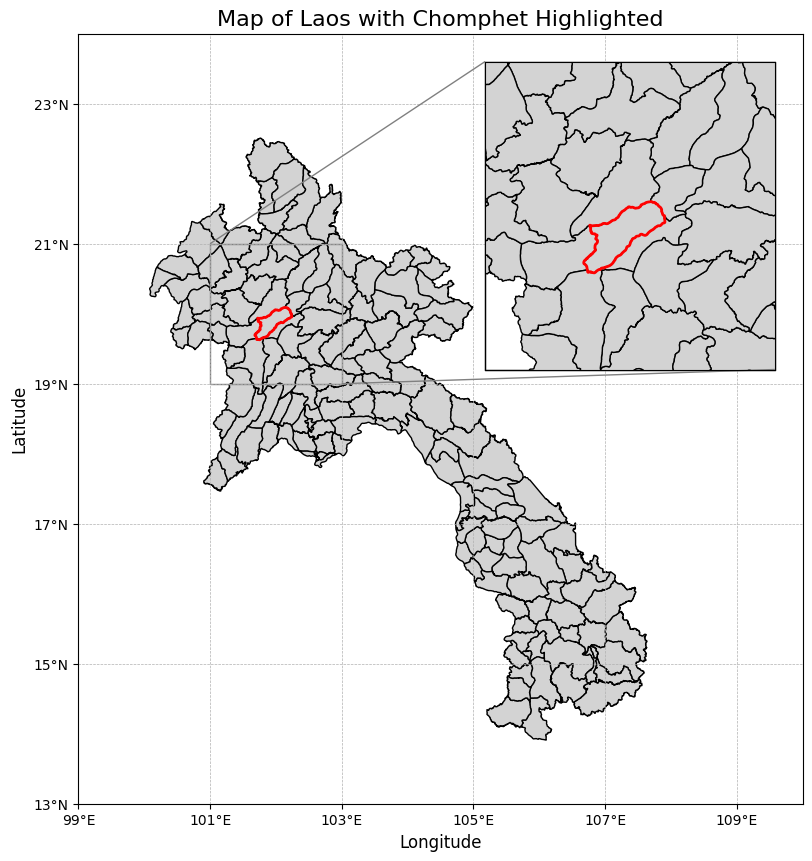

In [13]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

aoi.plot(ax=ax, edgecolor="black", color="lightgray")

chomphet.boundary.plot(ax=ax, edgecolor="red", linewidth=2)

ax.set_title("Map of Laos with Chomphet Highlighted", fontsize=16)

ax.set_xlabel("Longitude", fontsize=12)
ax.set_ylabel("Latitude", fontsize=12)

ax.grid(True, which="both", linestyle="--", linewidth=0.5)


xmin, xmax = 99, 110
ymin, ymax = 13, 24
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)

ax.set_xticks(range(xmin, xmax + 1, 2))
ax.set_yticks(range(ymin, ymax + 1, 2))

ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x}°E"))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, pos: f"{y}°N"))

ax_inset = inset_axes(ax, width="40%", height="40%", loc="upper right", borderpad=2)

aoi.plot(ax=ax_inset, edgecolor="black", color="lightgray")
chomphet.boundary.plot(ax=ax_inset, edgecolor="red", linewidth=2)

inset_xmin, inset_xmax = 101, 103
inset_ymin, inset_ymax = 19, 21
ax_inset.set_xlim(inset_xmin, inset_xmax)
ax_inset.set_ylim(inset_ymin, inset_ymax)

ax_inset.set_xticks([])
ax_inset.set_yticks([])

ax_inset.patch.set_edgecolor("black")
ax_inset.patch.set_linewidth(1)

mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")

plt.show()

In [16]:
def clip_and_analyze(data, aoi_geometry):
    clipped_data = data.rio.clip([aoi_geometry], drop=True)
    return clipped_data

bfm_clipped = clip_and_analyze(bfm, aoi_geometry)
tree_cover_clipped = clip_and_analyze(tree_cover, aoi_geometry)
gfc_clipped = clip_and_analyze(gfc, aoi_geometry)

In [17]:
# Create forest loss mask from BFM and tree cover data (250m resolution)
def create_bfm_mask(bfm, tree_cover):
    magnitude = bfm[1].values
    tree_cover_values = tree_cover[0].values

    bfm_forest_loss = np.zeros_like(magnitude)
    bfm_forest_loss[(magnitude <= -0.05) & (tree_cover_values >= 30)] = 1

    return bfm_forest_loss


# Create forest loss mask from GFC data (30m resolution)
def create_gfc_mask(gfc):
    lossyear = gfc[1].values
    gfc_loss = np.zeros_like(lossyear)
    gfc_loss[lossyear >= 20] = 1  # Values >= 10 indicate forest loss after 2010

    return gfc_loss

In [18]:
extent_bfm = [
    bfm_clipped.rio.bounds()[0],  # left
    bfm_clipped.rio.bounds()[2],  # right
    bfm_clipped.rio.bounds()[1],  # bottom
    bfm_clipped.rio.bounds()[3],  # top
]

extent_gfc = [
    gfc_clipped.rio.bounds()[0],  # left
    gfc_clipped.rio.bounds()[2],  # right
    gfc_clipped.rio.bounds()[1],  # bottom
    gfc_clipped.rio.bounds()[3],  # top
]

from shapely.geometry import box

bfm_mask = create_bfm_mask(bfm_clipped, tree_cover_clipped)
gfc_mask = create_gfc_mask(gfc_clipped)

bfm_bounds_box = box(*bfm_clipped.rio.bounds())
aoi_clipped = aoi[aoi.intersects(bfm_bounds_box)]

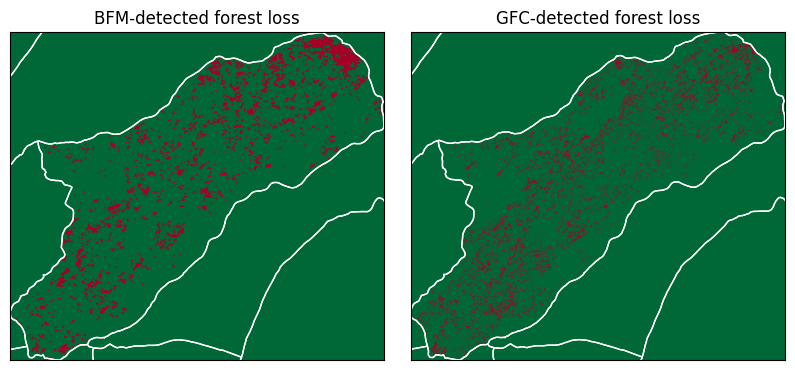

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

im1 = ax1.imshow(bfm_mask, cmap="RdYlGn_r", extent=extent_bfm)
aoi_clipped.boundary.plot(ax=ax1, edgecolor="white", linewidth=1)
ax1.set_title("BFM-detected forest loss")
ax1.set_xticks([])
ax1.set_yticks([])

im2 = ax2.imshow(gfc_mask, cmap="RdYlGn_r", extent=extent_gfc)
aoi_clipped.boundary.plot(ax=ax2, edgecolor="white", linewidth=1)
ax2.set_title("GFC-detected forest loss")
ax2.set_xticks([])
ax2.set_yticks([])

ax1.set_xlim(extent_bfm[0], extent_bfm[1])
ax1.set_ylim(extent_bfm[2], extent_bfm[3])

ax2.set_xlim(extent_gfc[0], extent_gfc[1])
ax2.set_ylim(extent_gfc[2], extent_gfc[3])

plt.subplots_adjust(wspace=0.07, hspace=0.1)
plt.show()

In [21]:
# Calculate areas (multiply pixel count by respective resolution squared)
bfm_area = np.sum(bfm_mask) * 0.25 * 0.25  # 250m resolution
gfc_area = np.sum(gfc_mask) * 0.03 * 0.03  # 30m resolution

print(f"Forest Loss Area Comparison:")
print(f"BFM-detected forest loss): {bfm_area:.2f} km²")
print(f"GFC-detected forest loss: {gfc_area:.2f} km²")

Forest Loss Area Comparison:
BFM-detected forest loss (250m): 170.88 km²
GFC-detected forest loss (30m): 137.87 km²
